In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
#import data
creep_df = pd.read_csv('../PI_Data/PI_Ni_superalloys_dataset.csv')

# Log transform of creep rupture life, then convert data type to float32
creep_df['log_creep_life'] = np.log10(creep_df['Creep life'])
creep_df = creep_df.drop(['Creep life'], axis=1)
creep_df = creep_df.astype('float32')
creep_df

,Ni,Al,Co,Cr,Mo,Re,Ru,Ta,W,Ti,Nb,T,Stress,PI Creep Feature,log_creep_life
0,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1100.0,137.0,944.638367,3.026370
1,59.799999,5.60,5.6,4.6,2.4,6.40,5.0,5.60,5.0,0.0,0.0,1000.0,245.0,952.328796,3.009026
2,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1000.0,245.0,952.328796,2.969556
3,61.680000,6.00,9.0,3.5,1.5,4.00,0.0,8.00,6.0,0.2,0.0,1100.0,120.0,831.518677,2.957607
4,50.570000,5.55,16.5,2.0,2.0,5.95,3.0,8.25,6.0,0.0,0.0,982.0,248.0,820.808655,2.939519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,210.0,13.599644,1.155336
148,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,280.0,11.414381,1.089905
149,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,225.0,8.838902,0.991226
150,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,220.0,10.204101,0.968483


In [3]:
creep_df.sort_values(by=['log_creep_life'], ascending=True, ignore_index=True, inplace=True)
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ni                152 non-null    float32
 1   Al                152 non-null    float32
 2   Co                152 non-null    float32
 3   Cr                152 non-null    float32
 4   Mo                152 non-null    float32
 5   Re                152 non-null    float32
 6   Ru                152 non-null    float32
 7   Ta                152 non-null    float32
 8   W                 152 non-null    float32
 9   Ti                152 non-null    float32
 10  Nb                152 non-null    float32
 11  T                 152 non-null    float32
 12  Stress            152 non-null    float32
 13  PI Creep Feature  152 non-null    float32
 14  log_creep_life    152 non-null    float32
dtypes: float32(15)
memory usage: 9.0 KB


In [4]:
# Extract features and targets
features = creep_df.iloc[:, 0:14]
targets = creep_df.iloc[:, 14]
features

,Ni,Al,Co,Cr,Mo,Re,Ru,Ta,W,Ti,Nb,T,Stress,PI Creep Feature
0,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,272.0,8.275208
1,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,220.0,10.204101
2,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,225.0,8.838902
3,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,280.0,11.414381
4,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,210.0,13.599644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,50.570000,5.55,16.5,2.0,2.0,5.95,3.0,8.25,6.0,0.0,0.0,982.0,248.0,820.808655
148,61.680000,6.00,9.0,3.5,1.5,4.00,0.0,8.00,6.0,0.2,0.0,1100.0,120.0,831.518677
149,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1000.0,245.0,952.328796
150,59.799999,5.60,5.6,4.6,2.4,6.40,5.0,5.60,5.0,0.0,0.0,1000.0,245.0,952.328796


In [5]:
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
Pearson CC: 0.9468800048318475
R2 score: 0.8948639821001231
RMSE: 0.11101453818267587
MAE: 0.08172818690890166
Coverage: 96.77419354838705
Pearson R2 median: 0.9468800048318475
R2 median: 0.8948639821001231
RMSE median: 0.11101453818267587
Interval Width: 0.45151809114563823
Composite Metric: 1.2794941219467186


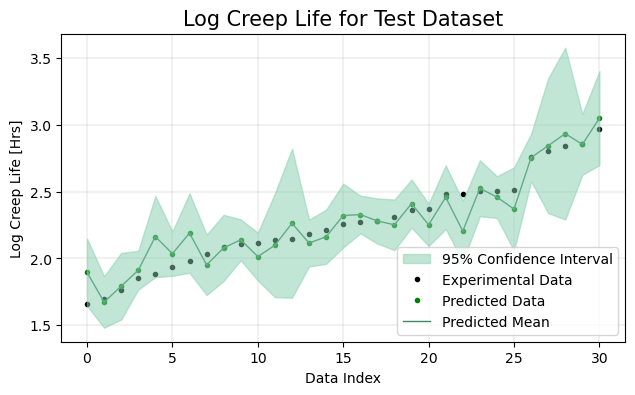

********************
Run # 1 Fold # 2
Pearson CC: 0.974267935565688
R2 score: 0.9468578023841905
RMSE: 0.10253183217417425
MAE: 0.07647679191041735
Coverage: 93.54838709677414
Pearson R2 median: 0.974267935565688
R2 median: 0.9468578023841905
RMSE median: 0.10253183217417425
Interval Width: 0.29462370412282723
Composite Metric: 1.5501529103658158


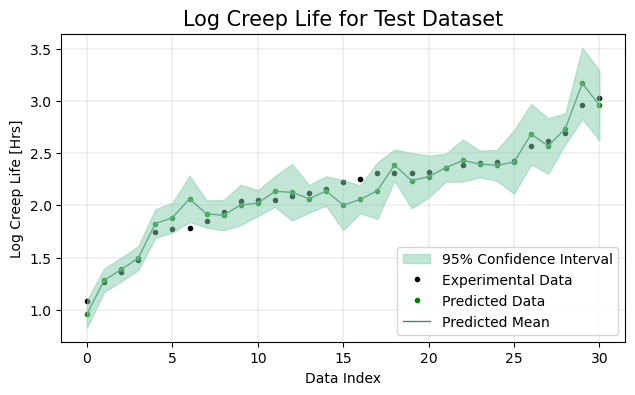

********************
Run # 1 Fold # 3
Pearson CC: 0.9712497509211624
R2 score: 0.9420888193532996
RMSE: 0.09648100717769327
MAE: 0.0668128041921257
Coverage: 93.33333333333331
Pearson R2 median: 0.9712497509211624
R2 median: 0.9420888193532996
RMSE median: 0.09648100717769327
Interval Width: 0.3409538515347297
Composite Metric: 1.4332370608945442


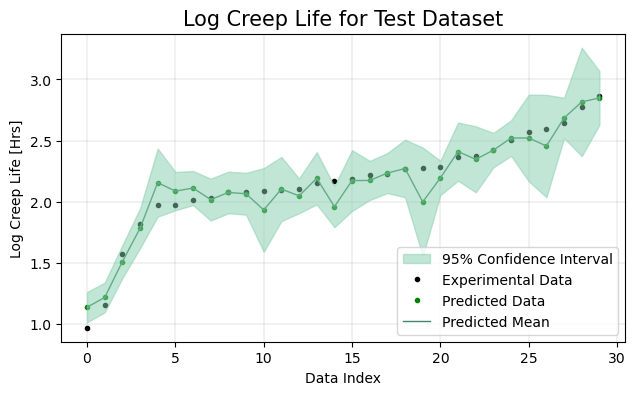

********************
Run # 1 Fold # 4
Pearson CC: 0.9783530336755872
R2 score: 0.9540818713527348
RMSE: 0.09335621121133512
MAE: 0.06553669728625922
Coverage: 93.33333333333331
Pearson R2 median: 0.9783530336755872
R2 median: 0.9540818713527348
RMSE median: 0.09335621121133512
Interval Width: 0.39651354111182036
Composite Metric: 1.3304954915259697


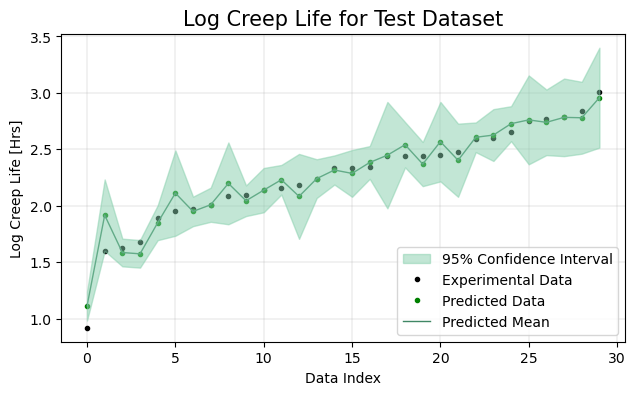

********************
Run # 1 Fold # 5
Pearson CC: 0.9674859118148098
R2 score: 0.927214742625071
RMSE: 0.1062604190996442
MAE: 0.07974631297485603
Coverage: 96.66666666666664
Pearson R2 median: 0.9674859118148098
R2 median: 0.927214742625071
RMSE median: 0.1062604190996442
Interval Width: 0.3764636559153194
Composite Metric: 1.3890747282553995


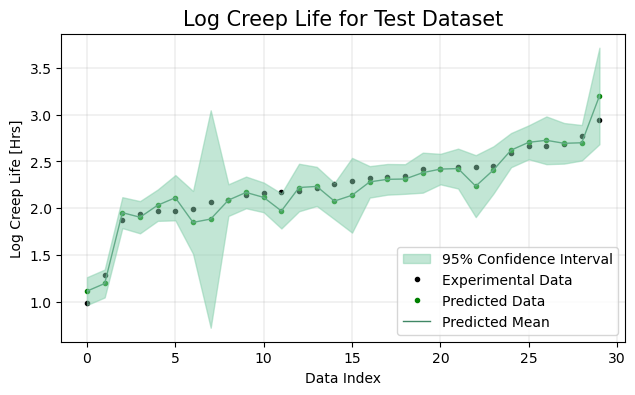

********************


In [6]:
# Evaluate multiple runs of the model
nruns = 1

nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)

median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)

            model.fit(X_train, y_train)

            mu_z, std_z = model.predict(X_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            df_test_low = y_pred_test - 2 * y_pred_unc_test
            df_test_median = y_pred_test
            df_test_high = y_pred_test + 2 * y_pred_unc_test

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
       
            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'Coverage: {test_coverage[j, i]}')

            print(f"Pearson R2 median: {pearsonr(y_test, df_test_median)[0]}")
            print(f"R2 median: {r2_score(y_test, df_test_median)}")
            print(f"RMSE median: {np.sqrt(mean_squared_error(y_test, df_test_median))}")
            
            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.

            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test 
            y_std = y_pred_unc_test
            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.squeeze(y_pred) - 2*np.squeeze(y_std), np.squeeze(y_pred) + 2*np.squeeze(y_std), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.squeeze(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            fig.delaxes(ax[1])

            plt.show()

            print(20*'*')

In [7]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.946880,0.894864,0.111015,0.081728,96.774194
1,0.974268,0.946858,0.102532,0.076477,93.548387
2,0.971250,0.942089,0.096481,0.066813,93.333333
3,0.978353,0.954082,0.093356,0.065537,93.333333
4,0.967486,0.927215,0.106260,0.079746,96.666667


In [8]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.967647,0.010979,0.933021,0.021009,0.101929,0.006401,0.07406,0.006666,94.731183,1.626466


In [9]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,96.774194,0.451518,1.279494
1,93.548387,0.294624,1.550153
2,93.333333,0.340954,1.433237
3,93.333333,0.396514,1.330495
4,96.666667,0.376464,1.389075


In [10]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,94.731183,1.626466,0.372015,0.052716,1.396491,0.092802
